In [1]:
from __future__ import annotations

from dataclasses import dataclass, field
from enum import Enum
from pathlib import Path

from IPython.display import Image, display  # type: ignore
from pydantic_ai import Agent
from pydantic_ai import messages as _messages
from pydantic_graph import BaseNode, End, Graph, GraphRunContext
from pydantic_graph.persistence.file import FileStatePersistence
from rich.console import Console
from rich.panel import Panel
from rich.prompt import Prompt
from rich.theme import Theme

# Set up Rich formatting
custom_theme = Theme(
    {
        "prompt": "cyan bold",
        "feedback": "bright_yellow",
        "todo": "bright_green",
        "task": "bright_magenta",
        "title": "white bold",
        "completion": "bright_cyan",
    }
)

console = Console(theme=custom_theme)
%load_ext autoreload
%autoreload 2

In [2]:
def user_message(content: str) -> _messages.ModelRequest:
    return _messages.ModelRequest(parts=[_messages.UserPromptPart(content=content)])


async def generate_experience(message_history: list[_messages.ModelMessage], experience: str = "") -> str:
    experience = experience or "None so far"
    experience_agent = Agent(
        model="google-gla:gemini-2.0-flash",
        system_prompt=(
            "Given the message history and the experience, update the experience.\n"
            "This experience will be fed back to the agent in the next run.\n"
            "So experience is not actually about what the agent has done or can do.\n"
            "It's more about learning from past runs and user feedback.\n"
            "Like humans, agents can learn from their mistakes and improve.\n"
            "Return only the experience string, no introduction or anything else. Not even the tags.\n"
        ),
    )
    message_history = _messages.ModelMessagesTypeAdapter.dump_python(message_history, mode="json")
    user_prompt = f"<experience>\n{experience}\n</experience>\n<messages>\n{message_history}\n</messages>"
    exp = await experience_agent.run(user_prompt=user_prompt)
    return exp.data


class TaskStatus(str, Enum):
    NOT_STARTED = "Not Started"
    IN_PROGRESS = "In Progress"
    COMPLETED = "Completed"


@dataclass
class Task:
    description: str
    status: TaskStatus = TaskStatus.NOT_STARTED
    notes: str = ""


@dataclass
class TaskGraphState:
    planner_message_history: list[_messages.ModelMessage] = field(default_factory=list)
    executor_message_history: list[_messages.ModelMessage] = field(default_factory=list)
    planner_experience: str = ""
    executor_experience: str = ""
    completed_tasks: list[Task] = field(default_factory=list)


@dataclass
class TaskGraphDeps:
    verify_todos: bool = True


@dataclass
class TaskCompletion:
    task: str
    todos: list[Task]
    completed_todos: list[Task]


@dataclass
class TaskPlanner(BaseNode[TaskGraphState, TaskGraphDeps]):
    task: str

    async def run(self, ctx: GraphRunContext[TaskGraphState, TaskGraphDeps]) -> VerifyTodos | TaskExecutor:
        planner = Agent(
            model="google-gla:gemini-2.0-flash",
            system_prompt=(
                "Given a task, create a detailed todo list with specific, actionable items.\n"
                "Be thorough and break complex tasks into manageable steps.\n"
                "Return a list of todos as strings with no additional text."
            ),
            result_type=list[str],
        )
        user_prompt = f"<task>\n{self.task}\n</task>"
        if ctx.state.planner_experience:
            user_prompt += f"\n<your_experience>\n{ctx.state.planner_experience}\n</your_experience>"
        todos = await planner.run(user_prompt=user_prompt, message_history=ctx.state.planner_message_history)
        ctx.state.planner_message_history = todos.all_messages()

        # Convert string todos to Task objects
        task_todos = [Task(description=todo) for todo in todos.data]

        if ctx.deps.verify_todos:
            return VerifyTodos(task=self.task, todos=task_todos)
        return TaskExecutor(task=self.task, todos=task_todos)


@dataclass
class VerifyTodos(BaseNode[TaskGraphState, TaskGraphDeps]):
    task: str
    todos: list[Task]

    async def run(self, ctx: GraphRunContext[TaskGraphState, TaskGraphDeps]) -> TaskPlanner | TaskExecutor:
        todos_text = "\n".join([f"• {todo.description}" for todo in self.todos])
        console.print(
            Panel(
                f"[todo]{todos_text}[/]",
                title=f"[title]Todo List for: {self.task}[/]",
                title_align="left",
                border_style="bright_green",
            )
        )
        feedback = Prompt.ask(
            "[prompt]Happy with this todo list? If yes, just press enter. If no, write your feedback[/]"
        )
        if feedback.strip():
            console.print(Panel(f"[feedback]{feedback}[/]", title="Your Feedback", title_align="left"))
            ctx.state.planner_message_history.append(user_message(feedback))
            ctx.state.planner_experience = await generate_experience(
                message_history=ctx.state.planner_message_history, experience=ctx.state.planner_experience
            )
            return TaskPlanner(task=self.task)
        return TaskExecutor(task=self.task, todos=self.todos)


@dataclass
class TaskExecutor(BaseNode[TaskGraphState, TaskGraphDeps, TaskCompletion]):
    task: str
    todos: list[Task]

    async def run(self, ctx: GraphRunContext[TaskGraphState, TaskGraphDeps]) -> TaskExecutor | End[TaskCompletion]:
        executor = Agent(
            model="google-gla:gemini-2.0-flash",
            system_prompt=(
                "You are a task executor that helps complete tasks based on a todo list.\n"
                "For each todo item, provide a detailed approach and solution.\n"
                "Be thorough and practical in your execution.\n"
                "Consider the relationships between tasks and how they fit into the overall goal.\n"
            ),
        )

        completed_todos: list[Task] = []

        # Create task context information
        todo_descriptions = [
            f"Task {i + 1}: {todo.description} - {todo.status}" for i, todo in enumerate(self.todos)
        ]
        task_context = "\n".join(todo_descriptions)

        for i, todo in enumerate(self.todos):
            if todo.status == TaskStatus.COMPLETED:
                completed_todos.append(todo)
                continue

            console.print(
                Panel(
                    f"[task]Currently working on: {todo.description}[/]",
                    title="[title]Task Execution[/]",
                    title_align="left",
                    border_style="bright_magenta",
                )
            )

            # Identify previous and next tasks for context
            previous_tasks = [t.description for t in self.todos[:i] if t.status == TaskStatus.COMPLETED]
            previous_context = "\n".join([f"- {task}" for task in previous_tasks]) if previous_tasks else "None"

            next_tasks = [t.description for t in self.todos[i + 1 :] if t.status != TaskStatus.COMPLETED]
            next_context = "\n".join([f"- {task}" for task in next_tasks]) if next_tasks else "None"

            user_prompt = (
                f"<main_task>\n{self.task}\n</main_task>\n"
                f"<all_todos>\n{task_context}\n</all_todos>\n"
                f"<previous_completed_tasks>\n{previous_context}\n</previous_completed_tasks>\n"
                f"<current_todo>\n{todo.description}\n</current_todo>\n"
                f"<upcoming_tasks>\n{next_context}\n</upcoming_tasks>"
            )

            if ctx.state.executor_experience:
                user_prompt += f"\n<your_experience>\n{ctx.state.executor_experience}\n</your_experience>"

            execution = await executor.run(
                user_prompt=user_prompt, message_history=ctx.state.executor_message_history
            )

            console.print(
                Panel(
                    f"[completion]{execution.data}[/]",
                    title=f"[title]Executed: {todo.description}[/]",
                    title_align="left",
                    border_style="bright_cyan",
                )
            )

            feedback = Prompt.ask(
                "[prompt]Task complete? If yes, press enter. If no, provide feedback or type 'skip' to move to next task[/]"
            )

            if not feedback.strip() or feedback.lower() == "yes":
                todo.status = TaskStatus.COMPLETED
                todo.notes = execution.data
                completed_todos.append(todo)
                console.print("[completion]✓ Marked as completed![/]")
            elif feedback.lower() == "skip":
                console.print("[feedback]Skipping this task for now[/]")
            else:
                console.print(Panel(f"[feedback]{feedback}[/]", title="Your Feedback", title_align="left"))
                ctx.state.executor_message_history.append(user_message(feedback))
                ctx.state.executor_experience = await generate_experience(
                    message_history=ctx.state.executor_message_history, experience=ctx.state.executor_experience
                )
                todo.notes += f"\nFeedback: {feedback}"

        # Check if all tasks are completed
        if len(completed_todos) == len(self.todos):
            console.print(
                Panel(
                    "[completion]All tasks have been completed successfully![/]",
                    title="[title]Task Completion[/]",
                    title_align="left",
                    border_style="bright_cyan",
                )
            )
            ctx.state.completed_tasks.extend(completed_todos)
            return End(TaskCompletion(task=self.task, todos=self.todos, completed_todos=completed_todos))
        else:
            # Some tasks are still incomplete, continue execution
            return TaskExecutor(task=self.task, todos=self.todos)


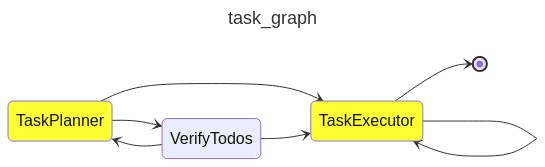

In [3]:
# Create the graph
task_graph = Graph(nodes=[TaskPlanner, VerifyTodos, TaskExecutor], auto_instrument=False)

# Create a run ID and set up persistence
run_id = "task_run_001"
state_path = Path(f"task_{run_id}.json")
state_path.unlink(missing_ok=True)
persistence = FileStatePersistence(state_path)
state = TaskGraphState()
deps = TaskGraphDeps()

# Visualize the graph
display(Image(task_graph.mermaid_image(direction="LR", highlighted_nodes=["TaskPlanner", "TaskExecutor"])))


In [4]:
async with task_graph.iter(
    start_node=TaskPlanner(task="give me report on ios vs android"),
    state=state,
    deps=deps,
    persistence=persistence,
) as run:
    async for node in run:
        print(f"Current node: {node.__class__.__name__}")


Current node: VerifyTodos


╭─ Todo List for: give me report on ios vs android ───────────────────────────────────────────────────────────────╮
│ • Research the current market share of iOS and Android operating systems.                                       │
│ • Analyze the demographics of iOS and Android users.                                                            │
│ • Compare the app ecosystems of iOS and Android, including the number of apps available, the quality of apps,   │
│ and the revenue generated by apps.                                                                              │
│ • Evaluate the hardware differences between iOS and Android devices, focusing on performance, features, and     │
│ price.                                                                                                          │
│ • Assess the security and privacy features of iOS and Android.                                                  │
│ • Summarize the strengths and weaknesses of each platform.                                                      │
│ • Write a conclusion on which platform is better for different use cases.                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Happy with this todo list? If yes, just press enter. If no, write your feedback:

╭─ Your Feedback ─────────────────────────────────────────────────────────────────────────────────────────────────╮
│ sure. just mention that we dont have web search. so just do it based on your own knowledge                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Current node: TaskPlanner
Current node: VerifyTodos


╭─ Todo List for: give me report on ios vs android ───────────────────────────────────────────────────────────────╮
│ • List the strengths and weaknesses of the iOS operating system based on existing knowledge.                    │
│ • List the strengths and weaknesses of the Android operating system based on existing knowledge.                │
│ • Compare the user interface and user experience of iOS and Android, based on existing knowledge.               │
│ • Compare the security and privacy features of iOS and Android, based on existing knowledge.                    │
│ • Compare the app availability and quality on iOS and Android, based on existing knowledge.                     │
│ • Summarize the key differences between iOS and Android.                                                        │
│ • Write a conclusion based on the comparison, highlighting which platform might be preferred for different user │
│ needs, based on existing knowledge.                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Happy with this todo list? If yes, just press enter. If no, write your feedback:

Current node: TaskExecutor


╭─ Task Execution ────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Currently working on: List the strengths and weaknesses of the iOS operating system based on existing           │
│ knowledge.                                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─ Executed: List the strengths and weaknesses of the iOS operating system based on existing knowledge. ──────────╮
│ Okay, let's start with the first task: listing the strengths and weaknesses of the iOS operating system.        │
│                                                                                                                 │
│ **Approach:**                                                                                                   │
│                                                                                                                 │
│ I will leverage my existing knowledge to list the strengths and weaknesses of iOS. I will focus on aspects like │
│ performance, security, user experience, ecosystem, and hardware integration. I will aim to be objective and     │
│ consider common perceptions and reported experiences.                                                           │
│                                                                                                                 │
│ **Solution:**                                                                                                   │
│                                                                                                                 │
│ **Strengths of iOS:**                                                                                           │
│                                                                                                                 │
│ *   **User-friendliness:** iOS is known for its intuitive and easy-to-learn interface. The consistent design    │
│ language across apps makes it easy for users to navigate and understand how to use new applications.            │
│ *   **Performance:** iOS generally offers smooth and responsive performance, especially on newer devices.       │
│ Apple's tight control over hardware and software allows for optimized performance.                              │
│ *   **Security:** iOS is considered to be a more secure operating system than Android. Apple has strict app     │
│ review processes and is quick to release security updates. The walled garden approach limits the potential for  │
│ malware and unauthorized access.                                                                                │
│ *   **Ecosystem Integration:** Apple devices and services integrate seamlessly. Features like Handoff, AirDrop, │
│ and iCloud make it easy to share data and switch between devices.                                               │
│ *   **Hardware Optimization:** Apple designs both the hardware and the software, allowing for deep              │
│ optimization. This results in better battery life and overall efficiency compared to Android devices with       │
│ similar hardware specifications.                                                                                │
│ *   **Resale Value:** iPhones generally retain their value longer than Android phones.                          │
│ *   **Regular Software Updates:** Apple provides consistent and timely software updates for several years,      │
│ ensuring that users have access to the latest features and security patches.                                    │
│ *   **Strong Privacy Focus:** Apple emphasizes user privacy and implements features to limit data tracking by   │
│ apps.                                                                                                           │
│                                                                                                                 │
│ **Weaknesses of iOS:**                                                                                          │
│                                                                                                                 │
│ *   **Limited Customization:** iOS offers less customization compared to Android. Users have limited control    │
│ over the appearance and functionality of the operating

Task complete? If yes, press enter. If no, provide feedback or type 'skip' to move to next task:

✓ Marked as completed!

╭─ Task Execution ────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Currently working on: List the strengths and weaknesses of the Android operating system based on existing       │
│ knowledge.                                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─ Executed: List the strengths and weaknesses of the Android operating system based on existing knowledge. ──────╮
│ Okay, I will now list the strengths and weaknesses of the Android operating system based on my existing         │
│ knowledge.                                                                                                      │
│                                                                                                                 │
│ **Task 2: List the strengths and weaknesses of the Android operating system based on existing knowledge.**      │
│                                                                                                                 │
│ **Strengths:**                                                                                                  │
│                                                                                                                 │
│ *   **Open Source and Customization:** Android's open-source nature allows for extensive customization by       │
│ manufacturers and users. This leads to a wide variety of devices with different features and price points.      │
│ Users can customize almost every aspect of the UI using launchers, widgets, and even custom ROMs.               │
│ *   **Hardware Variety:** Android runs on a vast range of devices from numerous manufacturers. This includes    │
│ phones, tablets, smartwatches, TVs, and even car infotainment systems. This provides consumers with a wider     │
│ selection of devices to choose from based on their budget and needs.                                            │
│ *   **Price Range:** Due to the open-source nature and variety of manufacturers, Android devices are available  │
│ across a wide price range, including many affordable options.                                                   │
│ *   **Open App Ecosystem:** Android allows users to install apps from various sources, not just the Google Play │
│ Store, offering greater flexibility.                                                                            │
│ *   **Integration with Google Services:** Android is tightly integrated with Google services such as Gmail,     │
│ Google Maps, Google Drive, and Google Assistant, which many users find convenient.                              │
│ *   **Developer Friendly:** The Android development environment is readily accessible, which fosters innovation │
│ and a large community of developers.                                                                            │
│ *   **Expandable Storage:** Many Android devices offer expandable storage via microSD card slots, which is      │
│ often absent in iOS devices.                                                                                    │
│ *   **Wider Hardware Support:** Android tends to support a broader range of hardware features and technologies. │
│                                                                                                                 │
│ **Weaknesses:**                                                                                                 │
│                                                                                                                 │
│ *   **Fragmentation:** The Android ecosystem suffers from fragmentation, with different devices running         │
│ different versions of the operating system. This can lead to inconsistencies in user experience and delays in   │
│ receiving updates.                                                                                              │
│ *   **Update Delays:** Due to manufacturer customization and carrier involvement, Android updates can be slow   │
│ to roll out to users, leaving devices vulnerable to security risks.                                             │
│ *   **Bloatware:** Some Android devices come pre-loaded with unnecessary apps (bloatware) installed by          │
│ manufacturers and carriers, which can consume storage 

Task complete? If yes, press enter. If no, provide feedback or type 'skip' to move to next task:

✓ Marked as completed!

╭─ Task Execution ────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Currently working on: Compare the user interface and user experience of iOS and Android, based on existing      │
│ knowledge.                                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─ Executed: Compare the user interface and user experience of iOS and Android, based on existing knowledge. ─────╮
│ Okay, let's compare the user interface (UI) and user experience (UX) of iOS and Android based on existing       │
│ knowledge.                                                                                                      │
│                                                                                                                 │
│ **Task 3: Compare the user interface and user experience of iOS and Android, based on existing knowledge.**     │
│                                                                                                                 │
│ **Approach:**                                                                                                   │
│                                                                                                                 │
│ I will break down the comparison into several aspects:                                                          │
│                                                                                                                 │
│ 1.  **Home Screen and Navigation:**  How users interact with the home screen, widgets, and system navigation.   │
│ 2.  **Customization:**  The level of customization available to the user.                                       │
│ 3.  **App Drawer:**  How apps are organized and accessed.                                                       │
│ 4.  **Notifications:**  How notifications are presented and managed.                                            │
│ 5.  **Overall Feel:**  Subjective assessment of the overall feel and flow of each OS.                           │
│                                                                                                                 │
│ **Solution:**                                                                                                   │
│                                                                                                                 │
│ Here's a comparison of the UI/UX of iOS and Android:                                                            │
│                                                                                                                 │
│ | Feature              | iOS                                                                                    │
│ | Android                                                                                                   |   │
│ Comparison                                                                                                      │
│ |                                                                                                               │
│ | -------------------- |                                                                                        │
│ ---------------------------------------------------------------------------------------------------------- |    │
│ ---------------------------------------------------------------------------------------------------------- |    │
│ --------------------------------------------------------------------------------------------------------------- │
│ ---------------------------------------------------------------------------------------------- |                │
│ | **Home Screen & Navigation** | Grid-based layout with icons. No app drawer (initially, now an App Library     │
│ exists). Gesture-based navigation. | Highly customizable home screens with widgets. App drawer for all apps.    │
│ Navigation bar with buttons (can also use gestures). | iOS focuses on simplicity and ease of use, with a        │
│ consistent and predictable experience. Android offers more flexibility and customization options, allowing      │
│ users to tailor the home screen to their preferences. |                                                         │
│ | **Customization**    | Limited customization options

Task complete? If yes, press enter. If no, provide feedback or type 'skip' to move to next task:

✓ Marked as completed!

╭─ Task Execution ────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Currently working on: Compare the security and privacy features of iOS and Android, based on existing           │
│ knowledge.                                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─ Executed: Compare the security and privacy features of iOS and Android, based on existing knowledge. ──────────╮
│ Okay, I will compare the security and privacy features of iOS and Android, based on my existing knowledge.      │
│                                                                                                                 │
│ **Approach:**                                                                                                   │
│                                                                                                                 │
│ I will outline the security and privacy features of both operating systems, highlighting their respective       │
│ strengths and weaknesses in these areas. I'll consider aspects like:                                            │
│                                                                                                                 │
│ *   App permissions and sandboxing                                                                              │
│ *   Data encryption                                                                                             │
│ *   Vulnerability patching and updates                                                                          │
│ *   Privacy policies and data collection practices                                                              │
│ *   Open-source vs. closed-source nature                                                                        │
│                                                                                                                 │
│ **Comparison of Security and Privacy Features: iOS vs. Android**                                                │
│                                                                                                                 │
│ *iOS*                                                                                                           │
│                                                                                                                 │
│ *   **Strengths:**                                                                                              │
│     *   **Stronger App Sandboxing:** iOS is known for its robust app sandboxing, which isolates apps from each  │
│ other and the core system, limiting the potential damage from malicious apps.                                   │
│     *   **Tighter Control over App Store:** Apple has stricter app review processes, which reduces the          │
│ likelihood of malicious or low-quality apps making it into the App Store.                                       │
│     *   **Faster Security Updates:** Apple typically rolls out security updates to all supported devices        │
│ simultaneously, ensuring that users are protected against the latest threats more quickly.                      │
│     *   **Privacy-Focused Features:** Apple has emphasized privacy in recent years, introducing features like   │
│ Intelligent Tracking Prevention (ITP) in Safari, app tracking transparency (ATT), and privacy labels in the App │
│ Store.                                                                                                          │
│     *   **Hardware and Software Integration:** Apple's tight integration of hardware and software allows for    │
│ better security optimization and control.                                                                       │
│     *   **Data Encryption:** iOS devices have full disk encryption enabled by default.                          │
│                                                                                                                 │
│ *   **Weaknesses:**                                                                                             │
│     *   **Closed-Source Nature:** The closed-source nature of iOS means that security researchers have less     │
│ visibility into the underlying code, which can make it

Task complete? If yes, press enter. If no, provide feedback or type 'skip' to move to next task:

✓ Marked as completed!

╭─ Task Execution ────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Currently working on: Compare the app availability and quality on iOS and Android, based on existing knowledge. │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─ Executed: Compare the app availability and quality on iOS and Android, based on existing knowledge. ───────────╮
│ Okay, let's dive into comparing app availability and quality on iOS and Android.                                │
│                                                                                                                 │
│ **Task 5: Compare the app availability and quality on iOS and Android, based on existing knowledge.**           │
│                                                                                                                 │
│ **Approach:**                                                                                                   │
│                                                                                                                 │
│ 1.  **App Availability:** Discuss the size of the app stores (Apple App Store vs. Google Play Store), focusing  │
│ on which platform generally has a larger number of apps. Also consider the availability of niche or specialized │
│ apps on each platform.                                                                                          │
│ 2.  **App Quality:** Compare and contrast the general quality of apps on each platform, considering factors     │
│ such as performance, stability, and user interface consistency. Touch on the review process differences and how │
│ that affects the quality.                                                                                       │
│ 3.  **Exclusives:** Discuss any notable app exclusives for either platform.                                     │
│ 4.  **Monetization and Developer Ecosystem:** Consider how the different monetization strategies and developer  │
│ ecosystems affect the types of apps that are created for each platform.                                         │
│                                                                                                                 │
│ **Solution:**                                                                                                   │
│                                                                                                                 │
│ **App Availability:**                                                                                           │
│                                                                                                                 │
│ *   **Android (Google Play Store):** Generally boasts a higher number of available apps compared to iOS. This   │
│ is partly due to the more open nature of the Android platform, allowing for easier app submission. This sheer   │
│ volume can be an advantage, offering a wider range of choices, particularly for niche or specialized            │
│ applications. However, this can also mean navigating a larger pool of potentially lower-quality or even         │
│ malicious apps.                                                                                                 │
│ *   **iOS (Apple App Store):** While typically having fewer apps overall, the Apple App Store maintains a       │
│ stricter review process. This often results in a curated selection, but potentially at the cost of some niche   │
│ apps or those that push the boundaries of what's allowed.                                                       │
│                                                                                                                 │
│ **App Quality:**                                                                                                │
│                                                                                                                 │
│ *   **iOS:** Historically, iOS has been perceived as having higher app quality on average. This is attributed   │
│ to the rigorous Apple App Store review process, which focuses on factors like performance, stability, user      │
│ interface design, and security. The more homogeneous h

Task complete? If yes, press enter. If no, provide feedback or type 'skip' to move to next task:

✓ Marked as completed!

╭─ Task Execution ────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Currently working on: Summarize the key differences between iOS and Android.                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─ Executed: Summarize the key differences between iOS and Android. ──────────────────────────────────────────────╮
│ Okay, I'm on it. The current task is to summarize the key differences between iOS and Android, building upon    │
│ the previously completed tasks which outlined the strengths, weaknesses, UI/UX, security/privacy, and app       │
│ availability/quality of each platform.                                                                          │
│                                                                                                                 │
│ Here's my approach:                                                                                             │
│                                                                                                                 │
│ 1.  **Review Previous Tasks:** Quickly review my notes from the previous tasks to refresh my memory of the key  │
│ points.                                                                                                         │
│ 2.  **Identify Overlapping Themes:** Look for overarching themes or categories where the differences are most   │
│ pronounced.                                                                                                     │
│ 3.  **Concise Summary:** Write a concise summary highlighting these key differences, using clear and simple     │
│ language.                                                                                                       │
│                                                                                                                 │
│ Here's the summary:                                                                                             │
│                                                                                                                 │
│ **Key Differences Between iOS and Android**                                                                     │
│                                                                                                                 │
│ | Feature           | iOS                                    | Android                                       |  │
│ | ----------------- | --------------------------------------- | --------------------------------------------- | │
│ | **Ecosystem**     | Closed, tightly controlled by Apple      | Open, controlled by Google, various            │
│ manufacturers |                                                                                                 │
│ | **User Interface** | Consistent, intuitive, and user-friendly | More customizable, can vary by manufacturer   │
│ |                                                                                                               │
│ | **Hardware**       | Limited to Apple devices                 | Wide variety of devices from different brands │
│ |                                                                                                               │
│ | **App Availability**| Focus on quality and curated selection | Larger quantity, varying quality             | │
│ | **Security**      | Generally considered more secure        | Historically more vulnerable, improving rapidly │
│ |                                                                                                               │
│ | **Privacy**       | Stronger privacy protections             | More data collection, customizable settings |  │
│ | **Customization** | Limited customization options           | High level of customization                     │
│ |                                                                                                               │
│ | **Price**         | Generally more expensive                 | Wide range of price points                     │
│ |                                                                                                               │
│                                                       

Task complete? If yes, press enter. If no, provide feedback or type 'skip' to move to next task:

✓ Marked as completed!

╭─ Task Execution ────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Currently working on: Write a conclusion based on the comparison, highlighting which platform might be          │
│ preferred for different user needs, based on existing knowledge.                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─ Executed: Write a conclusion based on the comparison, highlighting which platform might be preferred for diffe─╮
│ Okay, I'm on the final task: writing a conclusion that highlights which platform (iOS or Android) might be      │
│ preferred for different user needs based on my existing knowledge.                                              │
│                                                                                                                 │
│ Here's my approach: I will synthesize the information gathered in the previous tasks, specifically focusing on  │
│ the strengths and weaknesses of each platform across various aspects (UI/UX, security, app availability, etc.). │
│ Based on these considerations, I will suggest which platform might be a better fit for different user profiles, │
│ keeping in mind common user priorities.                                                                         │
│                                                                                                                 │
│ Here's the concluding paragraph:                                                                                │
│                                                                                                                 │
│ In conclusion, both iOS and Android offer compelling mobile experiences, but cater to different priorities.     │
│ iOS, with its focus on simplicity, security, and seamless integration within the Apple ecosystem, is generally  │
│ preferred by users who prioritize ease of use, robust privacy features, and are heavily invested in other Apple │
│ products. Its curated app store often provides higher quality apps and a consistent user experience.  Android,  │
│ on the other hand, excels in customization, open-source flexibility, and a wider range of hardware options at   │
│ varying price points. This makes it a better choice for users who value personalization, are comfortable with   │
│ tinkering, and seek greater affordability. Furthermore, Android's broader app ecosystem, while sometimes        │
│ lacking the polish of iOS, offers greater choice and availability, especially in certain niche areas.           │
│ Ultimately, the "better" platform depends entirely on the individual user's needs, technical proficiency, and   │
│ budget.                                                                                                         │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Task complete? If yes, press enter. If no, provide feedback or type 'skip' to move to next task:

✓ Marked as completed!

╭─ Task Completion ───────────────────────────────────────────────────────────────────────────────────────────────╮
│ All tasks have been completed successfully!                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Current node: End


In [5]:
# View experiences after completion
print("\nPlanner experience:")
print(state.planner_experience)

print("\nExecutor experience:")
print(state.executor_experience)

print("\nCompleted Tasks:")
for task in state.completed_tasks:
    print(f"- {task.description} ({task.status})")


Planner experience:
The agent should be reminded that it does not have access to web search when generating to-do lists that require research. It needs to rely on its existing knowledge base. In the future, consider rephrasing tasks that require external information gathering to be more suitable for the agent's capabilities, or explore alternative methods for providing the agent with necessary data.


Executor experience:


Completed Tasks:
- List the strengths and weaknesses of the iOS operating system based on existing knowledge. (TaskStatus.COMPLETED)
- List the strengths and weaknesses of the Android operating system based on existing knowledge. (TaskStatus.COMPLETED)
- Compare the user interface and user experience of iOS and Android, based on existing knowledge. (TaskStatus.COMPLETED)
- Compare the security and privacy features of iOS and Android, based on existing knowledge. (TaskStatus.COMPLETED)
- Compare the app availability and quality on iOS and Android, based on existing 

In [9]:
print(state.completed_tasks[-1].notes)

Okay, I'm on the final task: writing a conclusion that highlights which platform (iOS or Android) might be preferred for different user needs based on my existing knowledge.

Here's my approach: I will synthesize the information gathered in the previous tasks, specifically focusing on the strengths and weaknesses of each platform across various aspects (UI/UX, security, app availability, etc.). Based on these considerations, I will suggest which platform might be a better fit for different user profiles, keeping in mind common user priorities.

Here's the concluding paragraph:

In conclusion, both iOS and Android offer compelling mobile experiences, but cater to different priorities. iOS, with its focus on simplicity, security, and seamless integration within the Apple ecosystem, is generally preferred by users who prioritize ease of use, robust privacy features, and are heavily invested in other Apple products. Its curated app store often provides higher quality apps and a consistent 